# Deeplab v3 실습

# Preliminaries

## Download VOC dataset

In [ ]:
import os
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [ ]:
project_path = './MyDrive/MyDrive/Voc/'

In [ ]:
# For download pascal voc 2007 dataset
from torchvision.datasets import VOCSegmentation

VOCSegmentation(root=os.path.join(project_path,'data'), year='2007', download=True)

Using downloaded and verified file: ./MyDrive/MyDrive/Segmentation_SKT/data/VOCtrainval_06-Nov-2007.tar
Extracting ./MyDrive/MyDrive/Segmentation_SKT/data/VOCtrainval_06-Nov-2007.tar to ./MyDrive/MyDrive/Segmentation_SKT/data


## Deeplab v3 (torchvision implemented version)

Torchvision에 구현되어있는 deeplab v3를 기준으로 구현하였다.

## Objective

- 다양한 object size가 들어오더라도 robust한 성능의 semantic segmentation model.
- Previous work
  - Fig. 2(a): 다양한 input size의 입력을 직접 넣어줌. 다양한 object size를 직접적으로 merge해서 받음.
  - Fig. 2(b): U-Net 구조. Encoder에서 다양한 크기의 feature map을 통해 다양한 크기의 필터를 사용한 효과.
  - Fig. 2(c), Deeper w. Atrous Convolution(Fig. 3)을 통한 큰 receptive field, stride=1로 축소되지 않은 feature map.
  - Fig. 2(d): 서로 다른 stride로 pooling을 진행, concat 하여 multi-scale feature map 생성


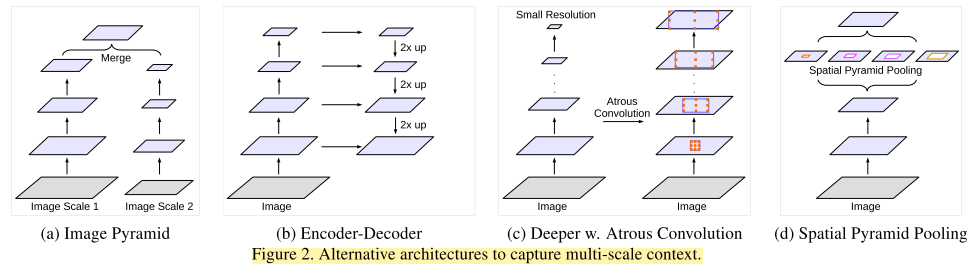

## Contribution

- Atrous convolution: 
  - 연산량을 늘리지 않으면서 receptive field를 늘림. (Fig. 2)
  - Feature map의 크기를 유지하면서 receptive field를 늘림. (Fig. 3)

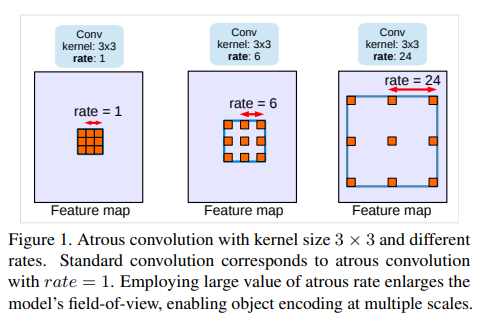


- Pixel-wise classification을 해야 하는 segmenatation task에서 축소되는 feature map은 불리하다. (output stride: input image 대비 feature map 크기의 비)
- Atrous Convolution(Fig. 3)을 통한 큰 receptive field, stride=1로 축소되지 않은 feature map.


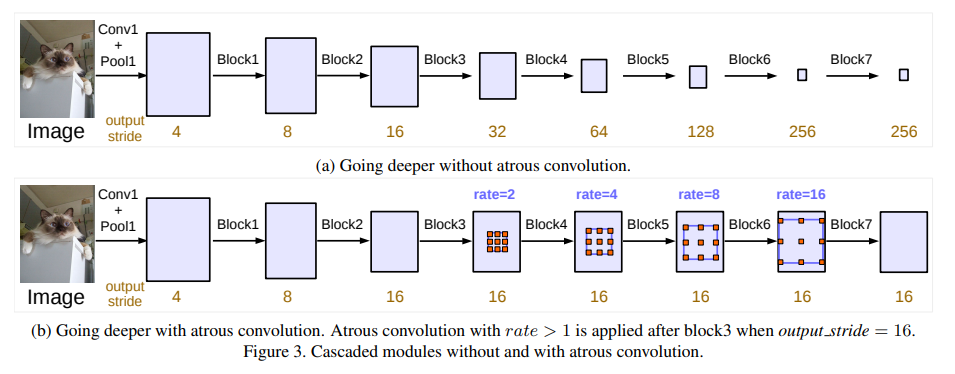

- ASPP (Atrous Spatial Pyramid Pooling): 
  - Encoder-decoder의 구조를 사용하지 않으면서 multi-scale feature를 받을 수 있는 구조.


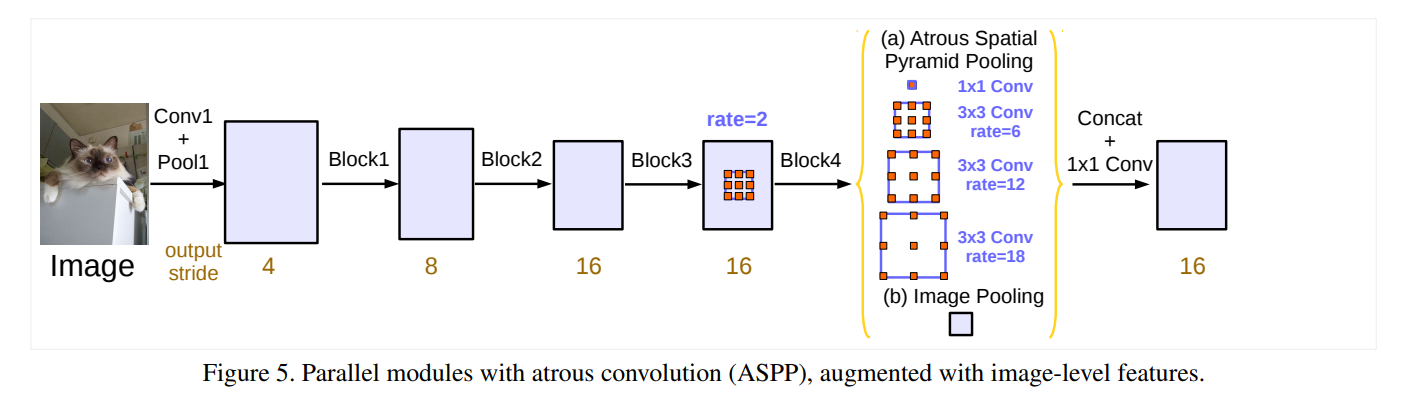

# Implement deeplab

- DeepLabV3
  - backbone = resnet101
  - classifier = DeepLabHead
    - DeepLabHead = ASPP + (Conv,BN,ReLU) + Conv

In [ ]:
from collections import OrderedDict

import torch
from torch import nn
from torch.nn import functional as F


class DeepLabV3(nn.Module):
    """
    Implements DeepLabV3 model from
    `"Rethinking Atrous Convolution for Semantic Image Segmentation"
    <https://arxiv.org/abs/1706.05587>`_.
    Args:
        backbone (nn.Module): the network used to compute the features for the model.
            The backbone should return an OrderedDict[Tensor], with the key being
            "out" for the last feature map used, and "aux" if an auxiliary classifier
            is used.
        classifier (nn.Module): module that takes the "out" element returned from
            the backbone and returns a dense prediction.
    """

    def __init__(self, backbone, classifier, aux_classifier=None):
        super(DeepLabV3, self).__init__()
        self.backbone = backbone
        self.classifier = classifier

    def forward(self, x):
        input_shape = x.shape[-2:]
        # contract: features is a dict of tensors
        features = self.backbone(x)

        result = OrderedDict()
        x = features["out"]
        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        result["out"] = x

        return result


class DeepLabHead(nn.Sequential):
    ''' Segmentation head (ASPP + (Conv,BN,ReLU) + Conv) '''
    def __init__(self, in_channels, num_classes):
        super(DeepLabHead, self).__init__(
            ASPP(in_channels, [12, 24, 36]),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1)
        )


class ASPPConv(nn.Sequential):
    ''' Convolution block (AtrousConv, BN, ReLU) '''
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation,
                      dilation=dilation, bias=False), # Just add `dilation`
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


class ASPPPooling(nn.Sequential):
    ''' Make 1x1 feature map Fig. 5(b) '''
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def forward(self, x):
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels,
                      out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)


# Pascal VOC 2007 dataset

In [ ]:
import os

import albumentations as A
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor
from torchvision.utils import save_image


class DatasetFromFolderVOC(Dataset):
    def __init__(self, root_dir= os.path.join(project_path, 'data/VOCdevkit/VOC2007'), txt_file='train.txt', transforms=None):
        super(DatasetFromFolderVOC, self).__init__()
        with open(os.path.join(root_dir, 'ImageSets/Segmentation', txt_file), 'r') as f:
            self.filenames = f.readlines()
        self.filenames = [file.strip() for file in self.filenames]
        self.img_path = os.path.join(root_dir, "JPEGImages")
        self.gt_path = os.path.join(root_dir, "SegmentationClass")
        self.transforms = transforms
        self.pallete = Image.open(os.path.join(self.gt_path, f'{self.filenames[0]}.png')).getpalette()

    # getitem 함수는 index에 맞는 data를 반환하는 역할을 합니다.
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, f'{self.filenames[index]}.jpg')).convert('RGB')
        gt = Image.open(os.path.join(self.gt_path, f'{self.filenames[index]}.png'))
        
        aug = self.transforms(image=np.array(img), mask=np.array(gt))
        img = to_tensor(aug['image'])
        gt = aug['mask']
        gt[gt > 20] = 0
        gt = torch.tensor(gt)

        return img, gt

    # len 함수는 Dataset 전체 개수를 반환합니다.
    def __len__(self):
        return len(self.filenames)



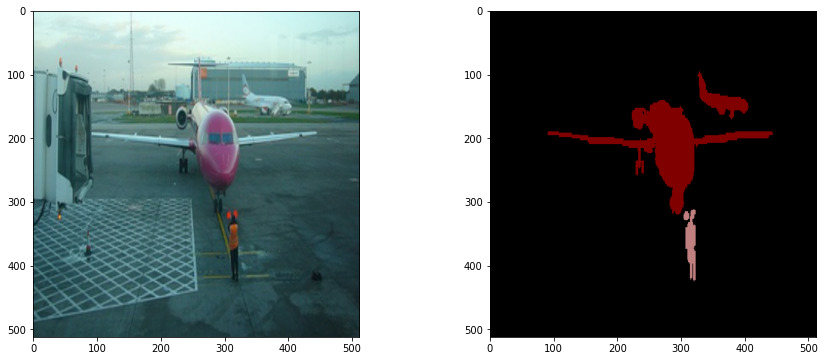

In [ ]:
import matplotlib.pyplot as plt


transforms = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(400, 400),
    A.HorizontalFlip(always_apply=True),
    # A.VerticalFlip(always_apply=True),
    A.Resize(512, 512),
])

dataset = DatasetFromFolderVOC(transforms=transforms)
img, gt = dataset[0]
pallete = dataset.pallete

gt_img = Image.fromarray(np.array(gt))
gt_img.putpalette(dataset.pallete)

# Show augmented image and gt
plt.rcParams["figure.figsize"] = (15, 6)
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(gt_img)

In [ ]:
from torch.utils.data import DataLoader


transforms = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(200, 200),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(256, 256),
])

trainDataSet = DatasetFromFolderVOC(txt_file='train.txt', transforms=transforms)
testDataSet = DatasetFromFolderVOC(txt_file='val.txt', transforms=transforms)

# Training Set과 Test Set을 각각 DataLoader에 넣습니다.
trainDataLoader = DataLoader(dataset=trainDataSet, num_workers=2, batch_size=8, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataSet, num_workers=1, batch_size=1, shuffle=False, drop_last=True)

# Train

In [ ]:
import torchvision

# Take-off last few layers of classifier
resnet101 = torchvision.models.resnet101(pretrained=True, replace_stride_with_dilation=[False, True, True])
return_layers = {'layer4': 'out'}
backbone = torchvision.models._utils.IntermediateLayerGetter(resnet101, return_layers)

num_classes = 21  # 20 + background
classifier = DeepLabHead(2048, num_classes)

model = DeepLabV3(backbone=backbone, classifier=classifier)

## Load pretrained model

### Model Description

Deeplabv3-ResNet101 is constructed by a Deeplabv3 model with a ResNet-101 backbone. The pre-trained model has been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

In [ ]:
model.load_state_dict(torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).state_dict(), strict=False)
model = model.cuda()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


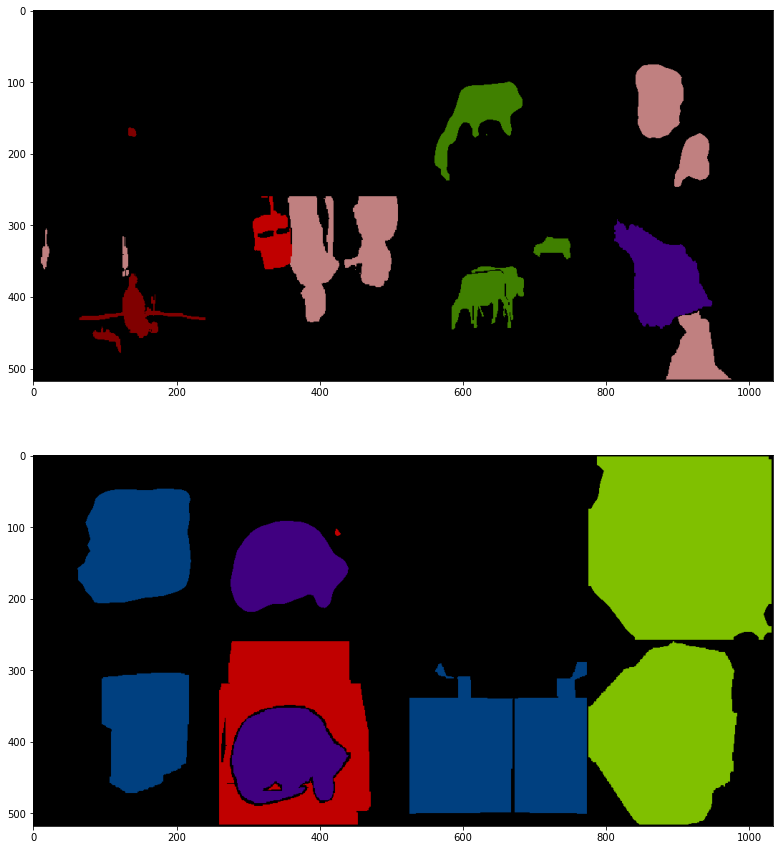

In [ ]:
# Visualization
model.eval()
num_imgs = 4
preds_train, gts_train = None, None
preds_val, gts_val = None, None
for i, (img, gt) in enumerate(trainDataLoader):
    if i * trainDataLoader.batch_size >= num_imgs:
        break
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)['out']
        output_pred = pred.argmax(1)
        for j in range(min(trainDataLoader.batch_size, 4)):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(trainDataSet.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            preds_train = out_img if i == 0 and j == 0 else torch.cat([preds_train, out_img])
            out_img = Image.fromarray(np.array(gt[j].cpu()).astype('uint8'))
            out_img.putpalette(trainDataSet.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            gts_train = out_img if i == 0 and j == 0 else torch.cat([gts_train, out_img])
            
for i, (img, gt) in enumerate(testDataLoader):
    if i * testDataLoader.batch_size >= num_imgs:
        break
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)['out']
        output_pred = pred.argmax(1)
        for j in range(min(testDataLoader.batch_size, num_imgs)):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(testDataSet.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            preds_test = out_img if i == 0 and j == 0 else torch.cat([preds_test, out_img])
            out_img = Image.fromarray(np.array(gt[j].cpu()).astype('uint8'))
            out_img.putpalette(testDataSet.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            gts_test = out_img if i == 0 and j == 0 else torch.cat([gts_test, out_img])

train_samples = torch.cat([preds_train.cpu(), gts_train])
train_samples = torchvision.utils.make_grid(train_samples, nrow=num_imgs)
train_samples = train_samples.permute(1, 2, 0)

test_samples = torch.cat([preds_test.cpu(), gts_test])
test_samples = torchvision.utils.make_grid(test_samples, nrow=num_imgs)
test_samples = test_samples.permute(1, 2, 0)

plt.rcParams["figure.figsize"] = (30, 15)
plt.subplot(2, 1, 1)
plt.imshow(train_samples)
plt.subplot(2, 1, 2)
plt.imshow(test_samples)

In [ ]:
import torch.optim as optim


# setup optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-6, betas=(0.9, 0.999))
model = model.cuda()
criterion = nn.CrossEntropyLoss()

In [ ]:
model = model.train()
total_epoch = 10
# Training
for epoch in range(total_epoch):
    for i, (img, gt) in enumerate(trainDataLoader):
        # forward
        img = img.cuda()
        gt = gt.long().cuda()

        pred = model(img)['out']

        loss = criterion(pred, gt)

        # Backprop + Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:        
            print(f'[{epoch+1}][{i+1}/{len(trainDataLoader)}] Loss: {loss.item():.3f}')


[1][1/26] Loss: 0.440
[1][11/26] Loss: 0.730
[1][21/26] Loss: 0.826
[2][1/26] Loss: 0.424
[2][11/26] Loss: 0.676


KeyboardInterrupt: ignored

In [ ]:
# Evaluate
model.eval()
running_loss = 0.0
for i, (img, gt) in enumerate(testDataLoader):
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)['out']
        loss = criterion(pred, gt)
        running_loss += loss

    if i % 10 == 0:
        print(f'[{i+1}/{len(testDataLoader)}] Loss: {running_loss.item()/(i+1):.3f}')

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}, 'checkpoint.pth')